In [2]:
# mtcnn demo
import sys
sys.path.insert(0,'/xuan/mtcnn/')
sys.path.insert(0,'/xuan/pycaffe-mtcnn')
import _init_paths
import caffe
import cv2
import numpy as np
#from python_wrapper import *
import os


In [3]:
import os
os.chdir("/xuan/mtcnn/")

In [4]:
minsize = 20
caffe_model_path = "./model"


In [5]:
threshold = [0.6, 0.7, 0.7]
factor = 0.709
   

### 获取模型信息


In [7]:
caffe.set_mode_gpu()
PNet = caffe.Net(caffe_model_path+"/det1.prototxt", caffe_model_path+"/det1.caffemodel", caffe.TEST)
RNet = caffe.Net(caffe_model_path+"/det2.prototxt", caffe_model_path+"/det2.caffemodel", caffe.TEST)
ONet = caffe.Net(caffe_model_path+"/det3.prototxt", caffe_model_path+"/det3.caffemodel", caffe.TEST)


## load images

In [6]:
image_path = '/xuan/tutorial/human.jpg'
im = cv2.imread(image_path)
im_bk  = cv2.cvtColor(im.copy(),cv2.COLOR_BGR2RGB)
im = im.astype(np.float32)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = np.transpose(im, (1,0,2)) 

image_height, image_width, num_channels = im.shape

print('Image shape:', im.shape)

('Image shape:', (3024, 4032, 3))


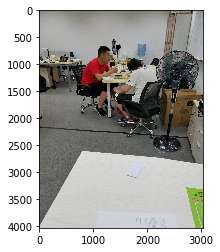

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(im_bk)

In [8]:
MIN_FACE_SIZE = 24.    # Minimum face size.
MIN_INPUT_SIZE = 12.   # Minimum input size.
m = MIN_INPUT_SIZE / MIN_FACE_SIZE
m

0.5

## 构造特征金字塔

In [9]:
min_size = min(image_height, image_width)
min_size = min_size * m
min_size

scales = []
counter = 0
FACTOR = 0.709
while min_size >= MIN_INPUT_SIZE:
    scales.append(m * FACTOR**counter)
    min_size = min_size * FACTOR
    counter = counter + 1
    print(min_size,scales[-1])
    

(1072.008, 0.5)
(760.053672, 0.3545)
(538.878053448, 0.25134049999999997)
(382.06453989463193, 0.17820041449999996)
(270.88375878529405, 0.12634409388049997)
(192.05658497877346, 0.08957796256127448)
(136.16811874995037, 0.06351077545594361)
(96.5431961937148, 0.04502913979826401)
(68.4491261013438, 0.03192566011696918)
(48.53043040585275, 0.022635293022931147)
(34.40807515774959, 0.016048422753258185)
(24.39532528684446, 0.011378331732060052)
(17.296285628372722, 0.008067237198030576)
(12.263066510516259, 0.0057196711734036785)
(8.694514155956027, 0.004055246861943208)


In [10]:
min_size

8.694514155956027

In [11]:
counter

15

## loading model



In [12]:
import time
# Load models.
prototxt = ['./model/' + x + '.prototxt' for x in ['det1', 'det2', 'det3']]
binary = ['./model/' + x + '.caffemodel' for x in ['det1', 'det2', 'det3']]
PNet = caffe.Net(prototxt[0], binary[0], caffe.TEST)
RNet = caffe.Net(prototxt[1], binary[1], caffe.TEST)
ONet = caffe.Net(prototxt[2], binary[2], caffe.TEST)

# Threshold for each stage.
# 用于进行NMS
THRESHOLD = [0.6, 0.7, 0.7]

t1 = time.time()

### resize images

('Resize to:', (1512, 2016, 3))


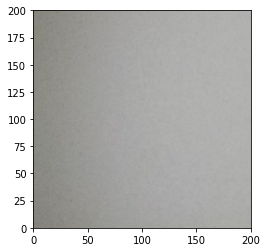

('Resize to:', (1073, 1430, 3))


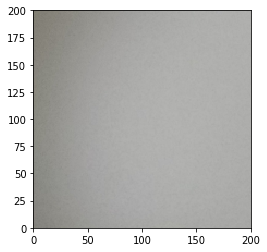

('Resize to:', (761, 1014, 3))


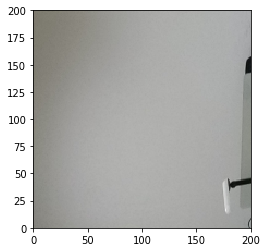

('Resize to:', (539, 719, 3))


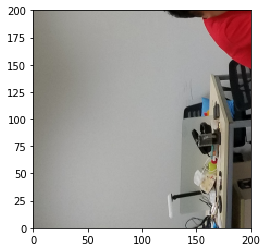

('Resize to:', (383, 510, 3))


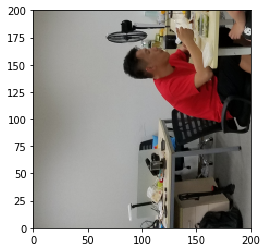

('Resize to:', (271, 362, 3))


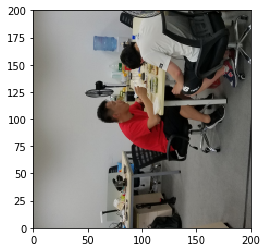

('Resize to:', (193, 257, 3))


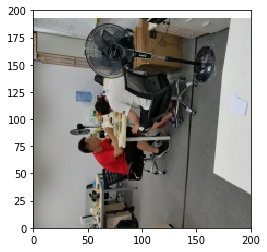

('Resize to:', (137, 182, 3))


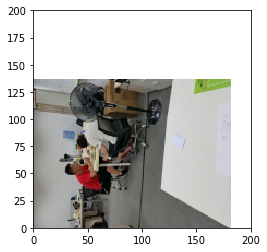

('Resize to:', (97, 129, 3))


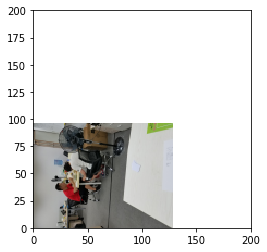

In [13]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
total_boxes = []
counter = 0
for scale in scales:
    # get the resize output
    hs = int(math.ceil(image_height*scale))
    ws = int(math.ceil(image_width*scale))
    im_resized = cv2.resize(im, (ws,hs), interpolation=cv2.INTER_AREA)
    print('Resize to:', im_resized.shape)
#     print(im_resized)
    plt.xlim([0,200])
    plt.ylim([0,200])
    plt.imshow(im_resized.astype(int))
    plt.show()
    counter +=1
    if counter == 9:
        break

### model structure

## PNet

### 可调参数：
    - nms
    - threshold of confidence

![pnet.png](https://github.com/anxu829/mtcnn-caffe/blob/master/12net/train12.png?raw=true)

In [14]:
from  utils import *

total_boxes = []

# ---------------------------------
# first stage

for scale in scales:
        # 获得该scale 下的框的信息 
        hs = int(math.ceil(image_height*scale))
        ws = int(math.ceil(image_width*scale))

        im_resized = cv2.resize(im, (ws,hs), interpolation=cv2.INTER_AREA)
        print('Resize to:', im_resized.shape)

        # H,W,C -> C,H,W
        im_resized = np.transpose(im_resized, (2,0,1))

        # Zero mean and normalization.
        im_resized = (im_resized - 127.5) * 0.0078125

        
        # feed image to PNet
        # use PNet
        # Reshape input layer.
        PNet.blobs['data'].reshape(1, 3, hs, ws)
        PNet.blobs['data'].data[...] = im_resized
        outputs = PNet.forward()
        # PNet 最后会有两个卷积结果：prob1 每个12*12的框是否人脸， conv4-2对每个12*12做坐标预测
        
        
        print(outputs.keys())
        print('prob',outputs['prob1'].shape)
        print('conv',outputs['conv4-2'].shape)
        
        threshold = THRESHOLD[0]
        confidence = outputs['prob1'][0][1]  # [H,W]
        regression = outputs['conv4-2'][0]   # [4,H,W]
        
        # get the place where has face ( relative to this scale)
        # y , x is the location of window
        y, x = np.where(confidence > threshold)
        
        # get the regression output of each 12*12 image
        reg_y1, reg_x1, reg_y2, reg_x2 = [regression[i,y,x] for i in range(4)]
        reg = np.array([reg_x1, reg_y1, reg_x2, reg_y2])

        
        scores = confidence[y,x]  # [N,]
        
        
        # x,y is the location of face in special scale
        # the rect = np.array([x1, y1, x2, y2]) is the location in the original input
        stride = 2
        cell_size = 12

        x1 = np.round((stride*x+1) / scale)
        y1 = np.round((stride*y+1) / scale)
        x2 = np.round((stride*x+1 + cell_size-1) / scale)
        y2 = np.round((stride*y+1 + cell_size-1) / scale)

        rect = np.array([x1, y1, x2, y2]) 
        
        bbox = np.vstack([rect, scores, reg])  # [9,N]
        bboxes = bbox.T
        
        
        # bbox = np.vstack([rect, scores, reg])
        #bboxes 包含：
            # rect: face rectangle ,  means the place of face
            # rect : is relative to orignial scale
            # scores : means the face probability
            # reg : is the result of regression
            
        # finished nms
        bboxes,_ = non_max_suppression(bboxes, 0.5)    
        print("bbox shape after nms",bboxes.shape)
        
        total_boxes.append(bboxes)
        print("="*50)
total_boxes = np.vstack(total_boxes)
print('total box has ', total_boxes.shape)
bboxes,_ = non_max_suppression(total_boxes, 0.7)
bboxes = bbox_regression(total_boxes)


('Resize to:', (1512, 2016, 3))
['conv4-2', 'prob1']
('prob', (1, 2, 751, 1003))
('conv', (1, 4, 751, 1003))
('bbox shape after nms', (217, 9))
('Resize to:', (1073, 1430, 3))
['conv4-2', 'prob1']
('prob', (1, 2, 532, 710))
('conv', (1, 4, 532, 710))
('bbox shape after nms', (123, 9))
('Resize to:', (761, 1014, 3))
['conv4-2', 'prob1']
('prob', (1, 2, 376, 502))
('conv', (1, 4, 376, 502))
('bbox shape after nms', (76, 9))
('Resize to:', (539, 719, 3))
['conv4-2', 'prob1']
('prob', (1, 2, 265, 355))
('conv', (1, 4, 265, 355))
('bbox shape after nms', (57, 9))
('Resize to:', (383, 510, 3))
['conv4-2', 'prob1']
('prob', (1, 2, 187, 250))
('conv', (1, 4, 187, 250))
('bbox shape after nms', (33, 9))
('Resize to:', (271, 362, 3))
['conv4-2', 'prob1']
('prob', (1, 2, 131, 176))
('conv', (1, 4, 131, 176))
('bbox shape after nms', (25, 9))
('Resize to:', (193, 257, 3))
['conv4-2', 'prob1']
('prob', (1, 2, 92, 124))
('conv', (1, 4, 92, 124))
('bbox shape after nms', (19, 9))
('Resize to:', (137,

## Rnet
### 注意到Rnet开始使用fc layer
### Rnet 的回归信息被使用到了
![RNET.png](https://github.com/anxu829/mtcnn-caffe/blob/master/24net/train24.png?raw=true)

In [15]:
# 从 bboxes 中拿到rect 信息
# 利用 rect 信息从原图中裁剪框(Pnet 一共返回 72个框定位置 )
# 把框 resize（到24*24得大小，注意第一步Pnet 没有使用到回归得结果，只使用了概率大于阈值得框得坐标）
# 然后 减均值除以方差 
inputs = get_inputs_from_bboxes(im, bboxes, 24)


print("Pnet input is ",inputs.shape)
N,C,H,W = inputs.shape


RNet.blobs['data'].reshape(N,3,H,W)
RNet.blobs['data'].data[...] = inputs
outputs = RNet.forward()
    
bboxes = get_rnet_boxes(bboxes, outputs, THRESHOLD[1])
print(bboxes.shape)
# after nms
bboxes,_ = non_max_suppression(bboxes, 0.7)
print('after nms',bboxes.shape)

('Pnet input is ', (596, 3, 24, 24))
(19, 9)
('after nms', (19, 9))


### about get_rnet_boxes

In [16]:

# RNet.blobs['data'].reshape(N,3,H,W)
# RNet.blobs['data'].data[...] = inputs
# outputs = RNet.forward()

# confidence = outputs['prob1'][:,1]
# regression = outputs['conv5-2']

# indices = np.where(confidence > threshold)
# rects = bboxes[indices][:,0:4]  # [N,4]
# scores = confidence[indices]    # [N,]
# scores = scores.reshape(-1,1)   # [N,1]
# regs = regression[indices]      # [N,4]

# bboxes = np.hstack([rects, scores, regs])

# bboxes,_ = non_max_suppression(bboxes, 0.7)
# bboxes = bbox_regression(bboxes)



In [17]:
bbw = bboxes[:,2] - bboxes[:,0] + 1
bbh = bboxes[:,3] - bboxes[:,1] + 1


x1 = bboxes[:,0]
y1 = bboxes[:,1]
x2 = bboxes[:,2]
y2 = bboxes[:,3]

scores = bboxes[:,4]

# Note the sequence.

# 所以regression 返回得四个结果就是系数

rgy1 = bboxes[:,5]
rgx1 = bboxes[:,6]
rgy2 = bboxes[:,7]
rgx2 = bboxes[:,8]

ret = np.vstack([x1 + rgx1 * bbw,
                 y1 + rgy1 * bbh,
                 x2 + rgx2 * bbw,
                 y2 + rgy2 * bbh,
                 scores])
bboxes = ret.T
print('bboxes regression result\'s shape : ',bboxes.shape)

("bboxes regression result's shape : ", (19, 5))


In [18]:
# bboxes = bbox_to_square(bboxes)
# code in bbox_to_square

square_bbox = bboxes.copy()

w = bboxes[:,2] - bboxes[:,0] + 1
h = bboxes[:,3] - bboxes[:,1] + 1
max_side = np.maximum(h,w)

square_bbox[:,0] = bboxes[:,0] + (w - max_side) * 0.5
square_bbox[:,1] = bboxes[:,1] + (h - max_side) * 0.5
square_bbox[:,2] = square_bbox[:,0] + max_side - 1
square_bbox[:,3] = square_bbox[:,1] + max_side - 1

bboxes = square_bbox

In [19]:
# bboxes = padding(bboxes, image_height, image_width)
# '''Padding bouding boxes the edge of image, if it's too large.'''、
im_width   = image_width
im_height  = image_height
bboxes[:,0] = np.maximum(0, bboxes[:,0])
bboxes[:,1] = np.maximum(0, bboxes[:,1])
bboxes[:,2] = np.minimum(im_width-1, bboxes[:,2])
bboxes[:,3] = np.minimum(im_height-1, bboxes[:,3])

### Onet


In [20]:
bboxes.shape

(19, 5)

In [21]:
# --------------------------------------------------------------
# Third stage.
#
inputs = get_inputs_from_bboxes(im, bboxes, 48)
N,C,H,W = inputs.shape

ONet.blobs['data'].reshape(N,3,H,W)
ONet.blobs['data'].data[...] = inputs
outputs = ONet.forward()

bboxes, points = get_onet_boxes(bboxes, outputs,THRESHOLD[2])
bboxes = bbox_regression(bboxes)

bboxes, picked_indices = non_max_suppression(bboxes, 0.7, 'min')
points = points[picked_indices]
bboxes = padding(bboxes, image_height, image_width)



In [22]:
bboxes.shape

(2, 5)

In [23]:
print('Drawing..')
im = im_bk
num_boxes = bboxes.shape[0]
for i in range(num_boxes):
    box = bboxes[i]
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])
    print('Rect:', y1, x1, y2, x2)
    # As im is rotated, so need to swap x and y.
    cv2.rectangle(im, (y1,x1), (y2,x2), (0,255,255), 2)

    if points.size:
        p = points[i]
        for i in range(5):
            x = int(p[i])
            y = int(p[i+5])
            # Again, swap x and y.
            cv2.circle(im, (y,x), 1, (0,0,255), 2)



Drawing..
('Rect:', 1161, 726, 1323, 999)
('Rect:', 1648, 954, 1674, 986)


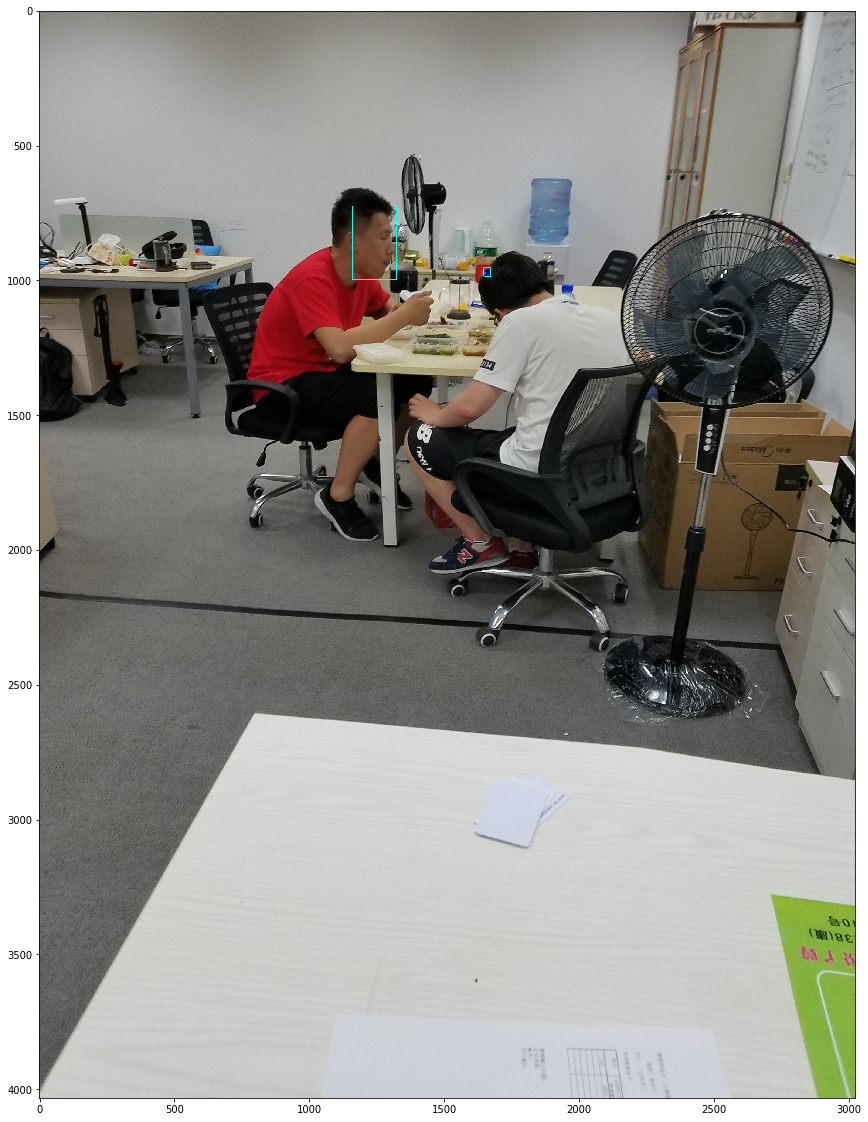

In [24]:
plt.figure(figsize=(20,20))
plt.imshow(im_bk)